In [1]:
import numpy as np
import imageio
import matplotlib.pyplot as plt
import os
import sys
import tensorflow as tf
import keras
import random

from tensorflow.keras import datasets, layers, models
import matplotlib.pyplot as plt

physical_devices = tf.config.experimental.list_physical_devices('GPU')
tf.config.experimental.set_memory_growth(physical_devices[0], True)

Using TensorFlow backend.


## For this project we are using a model-based methodology for Image Segmentation

### A metrica que utilizaremos pra treinar o nosso modelo eh a Intersection-Over-Union

Essa metrica consiste em calcular a area de sobreposição entre a segmentação prevista e a mascara dividido pela area de união entre a segmentação prevista e a mascara

In [20]:
from keras import backend as K

##Metrica
def iou_coef(y_true, y_pred, smooth=1):
    intersection = K.sum(K.abs(y_true * y_pred), axis=[1,2,3])
    union = K.sum(y_true,[1,2,3])+K.sum(y_pred,[1,2,3])-intersection
    iou = K.mean((intersection + smooth) / (union + smooth), axis=0)
  
    return iou

source: https://towardsdatascience.com/metrics-to-evaluate-your-semantic-segmentation-model-6bcb99639aa2

### Formando os arrays de imagens e mascaras

In [3]:
directory = os.fsencode("./new_maps")

images = []
titulos = []

list_directory = os.listdir(directory.decode("utf-8"))

list_directory.sort()
    
for file in list_directory:
    filename = os.fsdecode(file)
    titulos.append(filename)
    filename_path = directory.decode("utf-8") + "/" + filename
    img = imageio.imread(filename_path)
    images.append(img)
    
directory = os.fsencode("./new_masks")

masks = []
titulos = []

list_directory = os.listdir(directory.decode("utf-8"))

list_directory.sort()
    
for file in list_directory:
    filename = os.fsdecode(file)
    titulos.append(filename)
    filename_path = directory.decode("utf-8") + "/" + filename
    img = imageio.imread(filename_path)
    masks.append(img)
    
masks = np.array(masks)
images = np.array(images)

masks = np.expand_dims(masks, -1)

### Splitando os dados entre treino e teste

In [4]:
from sklearn.model_selection import train_test_split
train_images, test_images, train_masks, test_masks = train_test_split(images, masks, test_size=0.2)

### Criando o modelo

In [5]:
from keras.models import Model, load_model
import tensorflow as tf
from keras.layers import Input, Dropout
from keras.layers.convolutional import Conv2D, Conv2DTranspose
from keras.layers.pooling import MaxPooling2D
from keras.layers.merge import concatenate
from keras.optimizers import Adam
from keras.layers import BatchNormalization
import keras

In [6]:
def get_unet(input_img, dropout = 0.1):

    #Contração
    c1 = Conv2D(16, (3, 3), activation='relu', kernel_initializer='he_normal', padding='same') (input_img)
    c1 = BatchNormalization() (c1)
    c1 = Conv2D(16, (3, 3), activation='relu', kernel_initializer='he_normal', padding='same') (c1)
    c1 = BatchNormalization() (c1)
    p1 = MaxPooling2D((2, 2)) (c1)
    p1 = Dropout(dropout)(p1)

    c2 = Conv2D(32, (3, 3), activation='relu', kernel_initializer='he_normal', padding='same') (p1)
    c2 = BatchNormalization() (c2)
    c2 = Conv2D(32, (3, 3), activation='relu', kernel_initializer='he_normal', padding='same') (c2)
    c2 = BatchNormalization() (c2)
    p2 = MaxPooling2D((2, 2)) (c2)
    p2 = Dropout(dropout)(p2)

    c3 = Conv2D(64, (3, 3), activation='relu', kernel_initializer='he_normal', padding='same') (p2)
    c3 = BatchNormalization() (c3)
    c3 = Conv2D(64, (3, 3), activation='relu', kernel_initializer='he_normal', padding='same') (c3)
    c3 = BatchNormalization() (c3)
    p3 = MaxPooling2D((2, 2)) (c3)
    p3 = Dropout(dropout)(p3)

    c4 = Conv2D(128, (3, 3), activation='relu', kernel_initializer='he_normal', padding='same') (p3)
    c4 = BatchNormalization() (c4)
    c4 = Conv2D(128, (3, 3), activation='relu', kernel_initializer='he_normal', padding='same') (c4)
    c4 = BatchNormalization() (c4)
    p4 = MaxPooling2D(pool_size=(2, 2)) (c4)
    p4 = Dropout(dropout)(p4)
    
    c5 = Conv2D(256, (3, 3), activation='relu', kernel_initializer='he_normal', padding='same') (p4)
    c5 = BatchNormalization() (c5)
    c5 = Conv2D(256, (3, 3), activation='relu', kernel_initializer='he_normal', padding='same') (c5)
    c5 = BatchNormalization() (c5)

    #Expansão
    u6 = Conv2DTranspose(128, (2, 2), strides=(2, 2), padding='same') (c5)
    u6 = concatenate([u6, c4])
    u6 = Dropout(dropout)(u6)
    c6 = Conv2D(128, (3, 3), activation='relu', kernel_initializer='he_normal', padding='same') (u6)
    c6 = BatchNormalization() (c6)
    c6 = Conv2D(128, (3, 3), activation='relu', kernel_initializer='he_normal', padding='same') (c6)
    c6 = BatchNormalization() (c6)

    u7 = Conv2DTranspose(64, (2, 2), strides=(2, 2), padding='same') (c6)
    u7 = concatenate([u7, c3])
    u7 = Dropout(dropout)(u7)
    c7 = Conv2D(64, (3, 3), activation='relu', kernel_initializer='he_normal', padding='same') (u7)
    c7 = BatchNormalization() (c7)
    c7 = Conv2D(64, (3, 3), activation='relu', kernel_initializer='he_normal', padding='same') (c7)
    c7 = BatchNormalization() (c7)

    u8 = Conv2DTranspose(32, (2, 2), strides=(2, 2), padding='same') (c7)
    u8 = concatenate([u8, c2])
    c8 = Conv2D(32, (3, 3), activation='relu', kernel_initializer='he_normal', padding='same') (u8)
    c8 = BatchNormalization() (c8)
    c8 = Conv2D(32, (3, 3), activation='relu', kernel_initializer='he_normal', padding='same') (c8)
    c8 = BatchNormalization() (c8)

    u9 = Conv2DTranspose(16, (2, 2), strides=(2, 2), padding='same') (c8)
    u9 = concatenate([u9, c1])
    c9 = Conv2D(16, (3, 3), activation='relu', kernel_initializer='he_normal', padding='same') (u9)
    c9 = BatchNormalization() (c9)
    c9 = Conv2D(16, (3, 3), activation='relu', kernel_initializer='he_normal', padding='same') (c9)
    c9 = BatchNormalization() (c9)

    outputs = Conv2D(1, (1, 1), activation='sigmoid') (c9)

    model = Model(inputs=[input_img], outputs=[outputs])
    return model

In [7]:
input_img = Input((256,256,3))
model = get_unet(input_img, dropout=0.05)
model.compile(
        optimizer= Adam(),
        loss= "binary_crossentropy",
        #metrics=["accuracy"])
        #loss=soft_dice_loss,
        metrics=[iou_coef])
history = model.fit(train_images,
                    train_masks/255,
                    validation_split = 0.1,
                    batch_size = 16,
                    #validation_data = (test_images,test_masks),
                    epochs=30)

Train on 1839 samples, validate on 205 samples
Epoch 1/30
1839/1839 [==============================] - 49s 26ms/step - loss: 0.5306 - iou_coef: 0.0830 - val_loss: 0.3823 - val_iou_coef: 0.0588
Epoch 2/30
1839/1839 [==============================] - 31s 17ms/step - loss: 0.2509 - iou_coef: 0.1440 - val_loss: 0.1543 - val_iou_coef: 0.2134
Epoch 3/30
1839/1839 [==============================] - 31s 17ms/step - loss: 0.1391 - iou_coef: 0.2190 - val_loss: 0.1094 - val_iou_coef: 0.2342
Epoch 4/30
1839/1839 [==============================] - 31s 17ms/step - loss: 0.1003 - iou_coef: 0.2779 - val_loss: 0.0914 - val_iou_coef: 0.3095
Epoch 5/30
1839/1839 [==============================] - 32s 17ms/step - loss: 0.0838 - iou_coef: 0.3219 - val_loss: 0.0799 - val_iou_coef: 0.3383
Epoch 6/30
1839/1839 [==============================] - 32s 17ms/step - loss: 0.0764 - iou_coef: 0.3503 - val_loss: 0.0796 - val_iou_coef: 0.3714
Epoch 7/30
1839/1839 [==============================] - 32s 17ms/step - loss:

In [8]:
model.evaluate(test_images, test_masks)

512/512 [==============================] - 4s 8ms/step


[-130.27123355865479, 3.0208585262298584]

In [9]:
predictions = model.predict(test_images, verbose=1)

512/512 [==============================] - 3s 6ms/step


In [10]:
def normalization(img):
    m = img.min()
    M = img.max()
    print(m)
    print(M)
    return ((img-m)/(M-m))*1
def threshold(img):
    n = img.shape[0]
    m = img.shape[1]
    counter = 0
    for x in range (n):
        for y in range(m):
            if img[x,y] < img.mean():
                img[x,y] = 0
            else:
                img[x,y] = 255
                counter+=1
    return counter

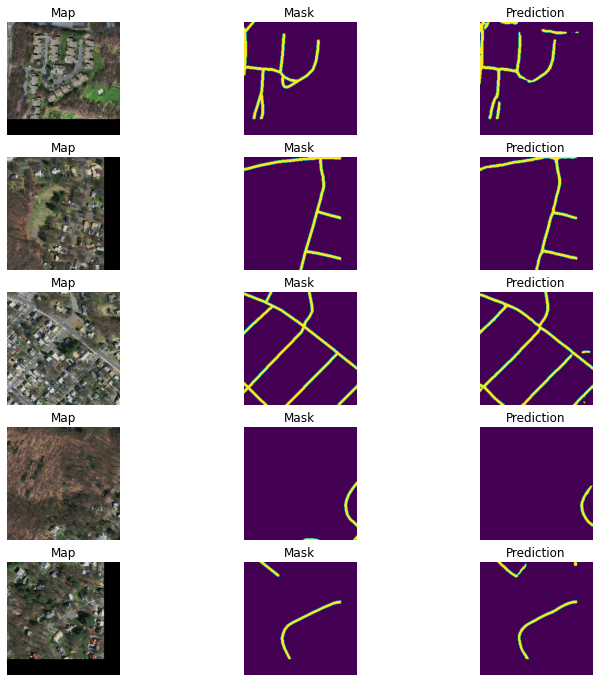

In [11]:
f = plt.figure(figsize=(12,12))
pred = (predictions > 0.5).astype(np.uint8)
for i in range(0,15,3):
    
    j = random.randint(1,137)
    f.add_subplot(5, 3, i+1)
    plt.imshow(test_images[j])
    plt.title("Map")
    plt.axis('off')

    f.add_subplot(5, 3, i+2)
    plt.imshow(np.squeeze(test_masks[j]))
    plt.title("Mask")
    plt.axis('off')

    f.add_subplot(5, 3, i+3)
    plt.imshow(np.squeeze(pred[j]))
    plt.title("Prediction")
    plt.axis('off')

plt.show()

In [12]:
model.save('my_model.h5') 

### Observacoes:

#### Devido ao dataset extremamente reduzido (somente 36 imagens para elaborar um esboco do projeto) e a arquitetura nada otimizada da CNN, os outputs gerados pelo modelo tem um resultado muito abaixo do esperado,

SANCA:

In [13]:
directory = os.fsencode("./new_sanca")

sanca_imgs = []
titulos = []

list_directory = os.listdir(directory.decode("utf-8"))

list_directory.sort()
    
for file in list_directory:
    filename = os.fsdecode(file)
    titulos.append(filename)
    filename_path = directory.decode("utf-8") + "/" + filename
    img = imageio.imread(filename_path)
    sanca_imgs.append(img)

sanca_imgs = np.array(sanca_imgs)

In [14]:
predictions = model.predict(sanca_imgs, verbose=1)

9/9 [==============================] - 1s 92ms/step


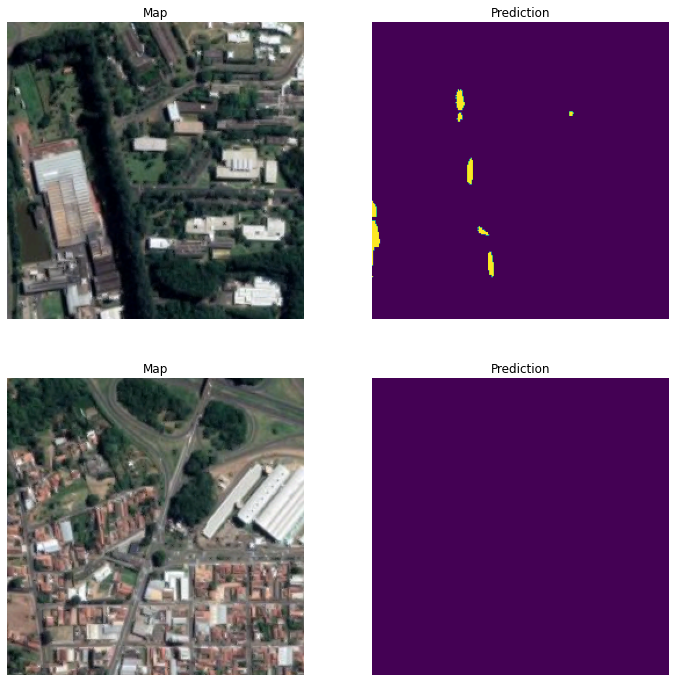

In [18]:
f = plt.figure(figsize=(12,12))
pred = (predictions > 0.5).astype(np.uint8)
for i in range(0,4,2):
    
    j = random.randint(0,8)
    f.add_subplot(2, 2, i+1)
    plt.imshow(sanca_imgs[j])
    plt.title("Map")
    plt.axis('off')

    f.add_subplot(2, 2, i+2)
    plt.imshow(np.squeeze(pred[j]))
    plt.title("Prediction")
    plt.axis('off')

plt.show()

In [26]:
model2 = load_model("my_model.h5", custom_objects= {'iou_coef': iou_coef})

In [30]:
model2.evaluate(test_images, test_masks)

512/512 [==============================] - 3s 6ms/step


[-130.27123355865479, 3.0208585262298584]

In [31]:
predictions = model2.predict(test_images, verbose=1)

512/512 [==============================] - 3s 6ms/step


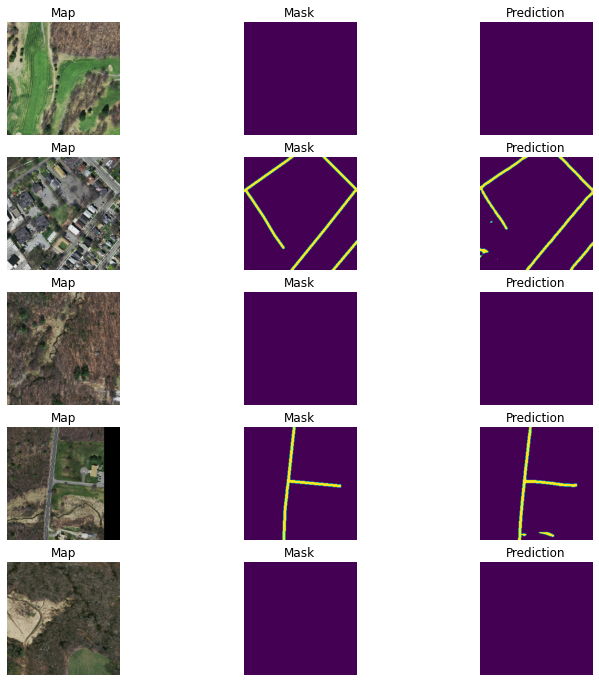

In [34]:
f = plt.figure(figsize=(12,12))
pred = (predictions > 0.5).astype(np.uint8)
for i in range(0,15,3):
    
    j = random.randint(1,137)
    f.add_subplot(5, 3, i+1)
    plt.imshow(test_images[j])
    plt.title("Map")
    plt.axis('off')

    f.add_subplot(5, 3, i+2)
    plt.imshow(np.squeeze(test_masks[j]))
    plt.title("Mask")
    plt.axis('off')

    f.add_subplot(5, 3, i+3)
    plt.imshow(np.squeeze(pred[j]))
    plt.title("Prediction")
    plt.axis('off')

plt.show()